loading images...
computing disparity...



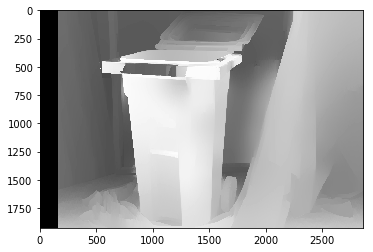

done
generating 3d point cloud...
out.ply saved


In [21]:
import numpy as np
from sklearn.preprocessing import normalize
import cv2
import matplotlib.pyplot as plt
 
print('loading images...')
imgL = cv2.imread('im0.png')  # downscale images for faster processing
imgR = cv2.imread('im1.png')
 
# SGBM Parameters -----------------
window_size = 3                     # wsize default 3; 5; 7 for SGBM reduced size image; 15 for SGBM full size image (1300px and above); 5 Works nicely

left_matcher = cv2.StereoSGBM_create(
    minDisparity=0,
    numDisparities=160,             # max_disp has to be dividable by 16 f. E. HH 192, 256
    blockSize=5,
    P1=8 * 3 * window_size ** 2,    # wsize default 3; 5; 7 for SGBM reduced size image; 15 for SGBM full size image (1300px and above); 5 Works nicely
    P2=32 * 3 * window_size ** 2,
    disp12MaxDiff=1,
    uniquenessRatio=15,
    speckleWindowSize=0,
    speckleRange=2,
    preFilterCap=63,
    mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
)

right_matcher = cv2.ximgproc.createRightMatcher(left_matcher)
 
# FILTER Parameters
lmbda = 80000
sigma = 1.2
visual_multiplier = 1.0
 
wls_filter = cv2.ximgproc.createDisparityWLSFilter(matcher_left=left_matcher)
wls_filter.setLambda(lmbda)
wls_filter.setSigmaColor(sigma)
 
print('computing disparity...')
displ = left_matcher.compute(imgL, imgR)  # .astype(np.float32)/16
dispr = right_matcher.compute(imgR, imgL)  # .astype(np.float32)/16
displ = np.int16(displ)
dispr = np.int16(dispr)
filteredImg = wls_filter.filter(displ, imgL, None, dispr)  # important to put "imgL" here!!!
 
filteredImg = cv2.normalize(src=filteredImg, dst=filteredImg, beta=0, alpha=255, norm_type=cv2.NORM_MINMAX);
filteredImg = np.uint8(filteredImg)
#cv2.imshow('Disparity Map', filteredImg)
#cv2.waitKey()
#cv2.destroyAllWindows()
#cv2.save.fig('recylcle.png')
print()
plt.imshow(filteredImg,'gray')
plt.show()
plt.imsave('recycle_sgbm.png',filteredImg)
print('done')

ply_header = '''ply
format ascii 1.0
element vertex %(vert_num)d
property float x
property float y
property float z
property uchar red
property uchar green
property uchar blue
end_header
'''

def write_ply(fn, verts, colors):
    verts = verts.reshape(-1, 3)
    colors = colors.reshape(-1, 3)
    verts = np.hstack([verts, colors])
    with open(fn, 'wb') as f:
        f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))
        np.savetxt(f, verts, fmt='%f %f %f %d %d %d ')

print('generating 3d point cloud...',)
h, w = imgL.shape[:2]
f = 0.8*w                          # guess for focal length
Q = np.float32([[1, 0, 0, -0.5*w],
                [0,-1, 0,  0.5*h], # turn points 180 deg around x-axis,
                [0, 0, 0,     -f], # so that y-axis looks up
                [0, 0, 1,      0]])
points = cv2.reprojectImageTo3D(filteredImg, Q)
colors = cv2.cvtColor(imgl, cv2.COLOR_BGR2RGB)
mask = filteredImg > filteredImg.min()
out_points = points[mask]
out_colors = colors[mask]
out_fn = 'out.ply'
write_ply('out.ply', out_points, out_colors)
print('%s saved' % 'out.ply')

loading images...
computing disparity...



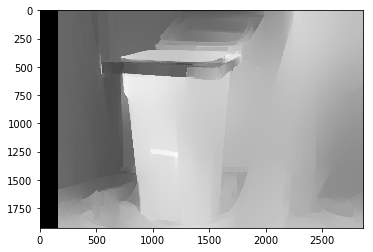

done
generating 3d point cloud...
out.ply saved


In [22]:
import numpy as np
from sklearn.preprocessing import normalize
import cv2
import matplotlib.pyplot as plt
 
print('loading images...')
imgL = cv2.imread('im0.png')  # downscale images for faster processing
imgR = cv2.imread('im1.png')
imgl = cv2.imread('im0.png')
 
# SGBM Parameters -----------------
#window_size = 3                     # wsize default 3; 5; 7 for SGBM reduced size image; 15 for SGBM full size image (1300px and above); 5 Works nicely

'''
left_matcher = cv2.StereoSGBM_create(
    minDisparity=0,
    numDisparities=160,             # max_disp has to be dividable by 16 f. E. HH 192, 256
    blockSize=5,
    P1=8 * 3 * window_size ** 2,    # wsize default 3; 5; 7 for SGBM reduced size image; 15 for SGBM full size image (1300px and above); 5 Works nicely
    P2=32 * 3 * window_size ** 2,
    disp12MaxDiff=1,
    uniquenessRatio=15,
    speckleWindowSize=0,
    speckleRange=2,
    preFilterCap=63,
    mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
)
'''
min_disp=0
num_disp=160
window_size=5
left_matcher = cv2.StereoBM_create(numDisparities = num_disp, blockSize = window_size)
left_matcher.setMinDisparity(min_disp)
left_matcher.setNumDisparities(num_disp)
left_matcher.setBlockSize(window_size)
left_matcher.setDisp12MaxDiff(1)
left_matcher.setUniquenessRatio(15)
left_matcher.setSpeckleRange(32)
left_matcher.setSpeckleWindowSize(100)
right_matcher = cv2.ximgproc.createRightMatcher(left_matcher)
 
# FILTER Parameters
lmbda = 80000
sigma = 1.2
visual_multiplier = 1.0
 
wls_filter = cv2.ximgproc.createDisparityWLSFilter(matcher_left=left_matcher)
wls_filter.setLambda(lmbda)
wls_filter.setSigmaColor(sigma)

imgL = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
imgR = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)
 
print('computing disparity...')
displ = left_matcher.compute(imgL, imgR)  # .astype(np.float32)/16
dispr = right_matcher.compute(imgR, imgL)  # .astype(np.float32)/16
displ = np.int16(displ)
dispr = np.int16(dispr)
filteredImg = wls_filter.filter(displ, imgL, None, dispr)  # important to put "imgL" here!!!
 
filteredImg = cv2.normalize(src=filteredImg, dst=filteredImg, beta=0, alpha=255, norm_type=cv2.NORM_MINMAX);
filteredImg = np.uint8(filteredImg)
#cv2.imshow('Disparity Map', filteredImg)
#cv2.waitKey()
#cv2.destroyAllWindows()
#cv2.save.fig('recylcle.png')
print()
plt.imshow(filteredImg,'gray')
plt.show()
plt.imsave('recycle_sgbm.png',filteredImg)
print('done')

ply_header = '''ply
format ascii 1.0
element vertex %(vert_num)d
property float x
property float y
property float z
property uchar red
property uchar green
property uchar blue
end_header
'''

def write_ply(fn, verts, colors):
    verts = verts.reshape(-1, 3)
    colors = colors.reshape(-1, 3)
    verts = np.hstack([verts, colors])
    with open(fn, 'wb') as f:
        f.write((ply_header % dict(vert_num=len(verts))).encode('utf-8'))
        np.savetxt(f, verts, fmt='%f %f %f %d %d %d ')

print('generating 3d point cloud...',)
h, w = imgL.shape[:2]
f = 0.8*w                          # guess for focal length
Q = np.float32([[1, 0, 0, -0.5*w],
                [0,-1, 0,  0.5*h], # turn points 180 deg around x-axis,
                [0, 0, 0,     -f], # so that y-axis looks up
                [0, 0, 1,      0]])
points = cv2.reprojectImageTo3D(filteredImg, Q)
colors = cv2.cvtColor(imgl, cv2.COLOR_BGR2RGB)
mask = filteredImg > filteredImg.min()
out_points = points[mask]
out_colors = colors[mask]
out_fn = 'out.ply'
write_ply('out.ply', out_points, out_colors)
print('%s saved' % 'out.ply')